<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/thushv89/gcp-tf-review-classification/blob/master/deploying_model_on_vertex_ai.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png"/>Run in Google Colab</a>
    </td>
</table>

## Prerequisites

Create a project called `gcp-tf-review-classification`

Enable Vertex AI API

Open this notebook in Google colab

In [ ]:
!pip3 install --upgrade  pydantic google-cloud-aiplatform google-cloud-storage "shapely<2" tensorflow-text==2.9.0

## Print tensorflow version

In [ ]:
import tensorflow as tf
print(tf.__version__)

## Authenticate to GCP

In [ ]:
from google.colab import auth
auth.authenticate_user()

## Importing required libraries

In [ ]:
import requests
import os
import tarfile
import random
import shutil
import numpy as np
import base64

## Setting environment variables

In [ ]:
PROJECT_ID = "gcp-tf-review-classification"
BUCKET_URI = "gs://imdb-movie-review-dataset" 
REGION = "us-central1"

In [ ]:
os.environ["PROJECT_ID"] = PROJECT_ID
os.environ["REGION"] = REGION
os.environ["BUCKET_URI"] = BUCKET_URI

In [ ]:
!gcloud config set project $PROJECT_ID

## Downloading the dataset

Here we are using a sentiment classification dataset by Stanford. 

Read more: https://ai.stanford.edu/~amaas/data/sentiment/

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

def maybe_download(url: str, download_dir: str = "data"):
    _, filename = os.path.split(url)
    download_path = os.path.join(download_dir, filename)

    if not os.path.exists(download_path):
        print("Downloading data")
        response = requests.get(url)
        os.makedirs(download_dir, exist_ok=True)

        with open(download_path, "wb") as f:
            f.write(response.content)
    else:
        print("File is already downloaded")

    tar = tarfile.open(download_path, "r:gz")
    tar.extractall(os.path.join(download_dir,"unzip"))
    tar.close()

maybe_download(url)

In [ ]:
def generate_truncated_dataset(dataset_dir: str, n=2000):
    """It takes painstakenly long time to create a vertex AI dataset.
    Therefore we're going to limit the data we'll be using"""

    n_per_label = n//2
    parent_dir, _ = os.path.split(dataset_dir)
    truncated_dir = os.path.join(parent_dir, "unzip_truncated")
    os.makedirs(truncated_dir, exist_ok=True)

    for sub_dir in [
        os.path.join("aclImdb", "train", "neg"), 
        os.path.join("aclImdb", "train", "pos"), 
        os.path.join("aclImdb", "test", "neg"), 
        os.path.join("aclImdb", "test", "pos")
    ]:

        os.makedirs(os.path.join(truncated_dir, sub_dir), exist_ok=True)
        for f in os.listdir(os.path.join(dataset_dir, sub_dir)):
        sample_id = int(f.split("_")[0])
        if sample_id < n_per_label:
            shutil.copy(os.path.join(dataset_dir, sub_dir, f), os.path.join(truncated_dir, sub_dir, f))

generate_truncated_dataset(os.path.join("data/unzip"))

## Create a GCS bucket

In [ ]:
%%bash

if $(gsutil ls $BUCKET_URI); then
    echo "Bucket ${BUCKET_URI} already exists.";
else
    echo "Bucket ${BUCKET_URI} doesn't exist. Creating a new one"
    gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI
fi

## Copy the data

In [ ]:
# -m for parallel copying
!gsutil -mq cp -r data/unzip_truncated/aclImdb/** $BUCKET_URI

## Managing json Schema with Pydantic

add links and info about the schema we have to use

In [ ]:
import pydantic 
from typing import Dict,List,Literal

class ClassificationAnnotation(pydantic.BaseModel):
    displayName: Literal["positive", "negative"]

class DataItemResourceLabels(pydantic.BaseModel):
    ml_use: Literal["training", "validation", "test"] = pydantic.Field(alias="aiplatform.googleapis.com/ml_use")
    # Enables us to use ml_use=<x> instead of the long field name
    class Config:
        allow_population_by_field_name = True

class TextClassificationSample(pydantic.BaseModel):
    textContent: str
    classificationAnnotation: ClassificationAnnotation 
    dataItemResourceLabels: DataItemResourceLabels

instance = TextClassificationSample(
    textContent="some review text", 
    classificationAnnotation=ClassificationAnnotation(displayName="positive"),
    dataItemResourceLabels=DataItemResourceLabels(ml_use="training")
)

print(instance.json(by_alias=True))

## Creating Vertex AI compatible instances

In [ ]:
from google.cloud import storage 
random.seed(946021)

# TODO: rename to read_from_gcs
def read_gcs_with_full_path(storage_client, bucket_name, blob_name):

    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(blob_name)

    with blob.open("r") as f:
        data = f.read()

    return data


def generate_single_instance(bucket_name, blob_name, ml_use, storage_client):

    label = None
    if blob_name.endswith(".txt"):
        if "pos" in blob_name:
            label = "positive"
        elif "neg" in blob_name:
            label = "negative"
        if label:
            instance = TextClassificationSample(
                textContent=read_gcs_with_full_path(
                    storage_client=storage_client,
                    bucket_name=bucket_name,
                    blob_name=blob_name, 
                ),
                classificationAnnotation=ClassificationAnnotation(displayName=label),
                dataItemResourceLabels=DataItemResourceLabels(ml_use=ml_use)
            )
            return instance
    return None

def create_instances(bucket_uri):

    storage_client = storage.Client()

    train_gcs_bucket_prefix = "train"
    test_gcs_bucket_prefix = "test"
    bucket_name = bucket_uri[5:]

    train_instances = []

    # delimiter only return the items in that directory (exclude subdirs)
    train_blobs = storage_client.list_blobs(bucket_name, prefix=train_gcs_bucket_prefix)
  
    print(f"Reading training data from the GCS bucket")
    for b in train_blobs:
        instance = generate_single_instance(
            bucket_name=bucket_name, blob_name=b.name, ml_use="training", storage_client=storage_client
        )
        if instance:
            train_instances.append(instance.json(by_alias=True)+'\n')
    print(f"\tFound {len(train_instances)} train instances")

    test_instances = []
    valid_count, test_count = 0,0

    test_blobs = storage_client.list_blobs(bucket_name, prefix=test_gcs_bucket_prefix)
    print(f"Reading test data from the GCS bucket")
    for b in test_blobs:
        if random.uniform(0,1.0)<0.5:
            valid_count += 1
            ml_use="validation"
        else:
            test_count += 1
            ml_use="test"

        instance = generate_single_instance(
            bucket_name=bucket_name, blob_name=b.name, ml_use=ml_use, storage_client=storage_client
        )
        if instance: 
            test_instances.append(instance.json(by_alias=True)+'\n')

    print(f"\tFound {valid_count} validation instances and {test_count} test instances")

    return train_instances, test_instances

train_instances, test_instances = create_instances(BUCKET_URI)

In [ ]:
print(train_instances[:1])

## Writing the data to GCS

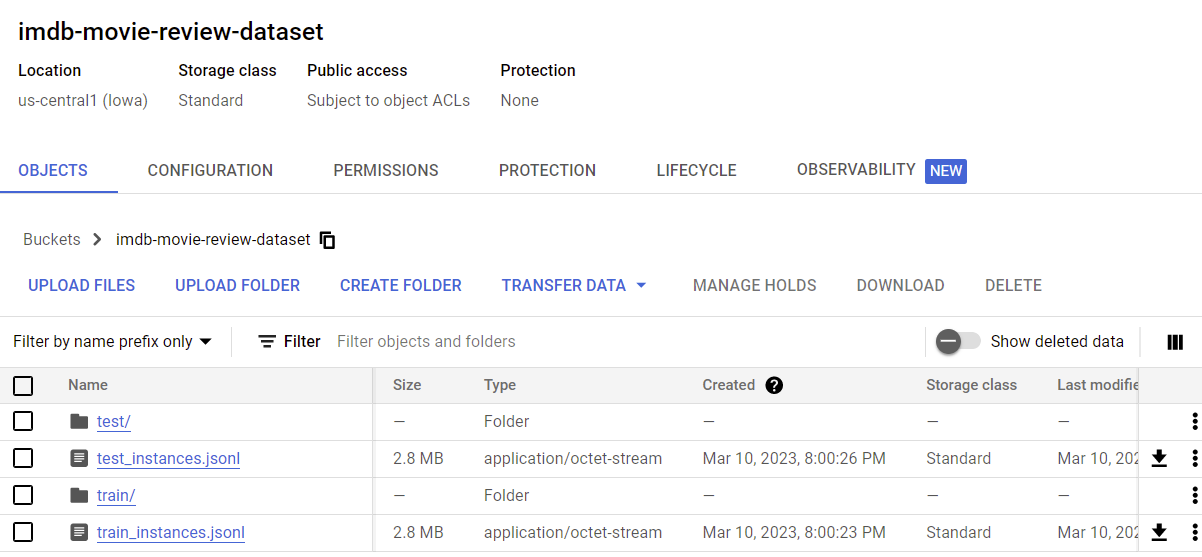

In [ ]:
import json

with open(os.path.join("data", "train_instances.jsonl"), "w") as f:
    f.writelines(train_instances)

with open(os.path.join("data", "test_instances.jsonl"), "w") as f:
    f.writelines(test_instances)

In [ ]:
!gsutil cp data/train_instances.jsonl $BUCKET_URI
!gsutil cp data/test_instances.jsonl $BUCKET_URI

## Creating a Vertex AI dataset

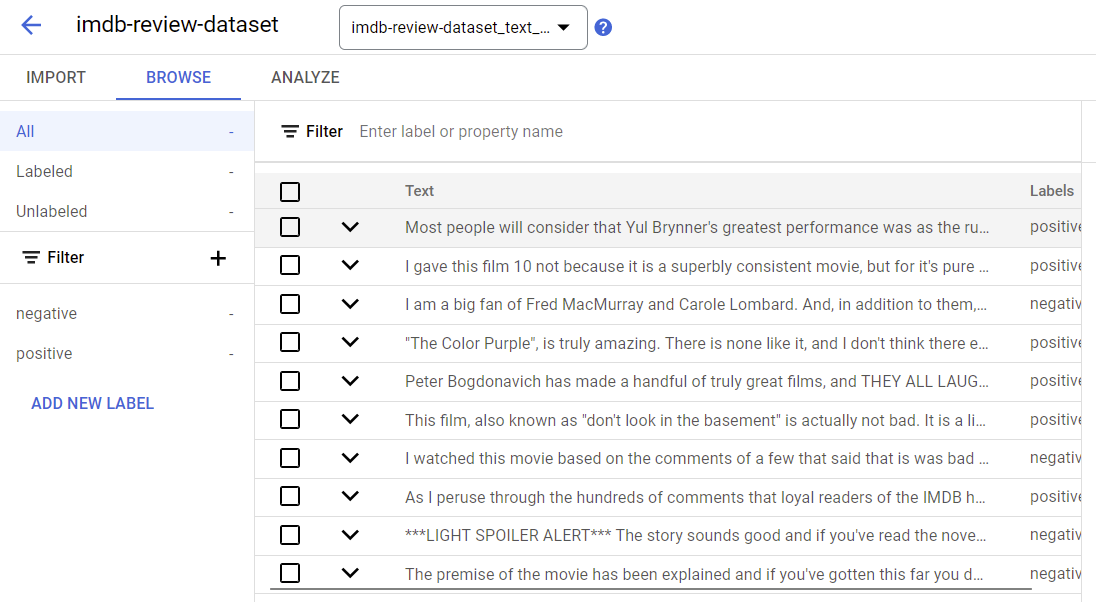

In [ ]:
DATASET_NAME = "imdb-review-dataset"

In [ ]:
from google.cloud import aiplatform

# Initialize the Vertex AI SDK
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

In [ ]:
schema_uris = [os.path.join(BUCKET_URI,f"{subset}_instances.jsonl") for subset in ["train", "test"]]

datasets = aiplatform.TextDataset.list()
dataset = None
dataset_exists = False
if len(datasets)>0:
    for ds in datasets:
        if ds.display_name == DATASET_NAME:
            print(f"Existing dataset found {ds.display_name} at {ds.gca_resource.name}")
            dataset = ds
            dataset_exists = True
            break
    
if not dataset_exists:
    print(f"Dataset with name {DATASET_NAME} was not found creating one...")
    dataset = aiplatform.TextDataset.create(
        display_name=DATASET_NAME, 
        gcs_source=schema_uris, 
        import_schema_uri=aiplatform.schema.dataset.ioformat.text.single_label_classification
    )

In [ ]:
JOB_NAME = "imdb_review_classification_automl_train"

MODEL_ID = "imdb-review-model"
MODEL_VERSION_ALIAS = "v0"

## This can take several hours to complete

## Quotas for custom models
`custom_model_training_cpus`
`custom_model_training_n2_cpus`
`all_regions_gpus`


```
training_job = aiplatform.AutoMLTextTrainingJob(
    display_name=JOB_NAME,
    prediction_type="classification",
)

# Use training_job.state to poll the current state of the job
model = training_job.run(
    dataset=dataset,
    training_filter_split="labels.aiplatform.googleapis.com/ml_use=training",
    validation_filter_split="labels.aiplatform.googleapis.com/ml_use=validation",
    test_filter_split="labels.aiplatform.googleapis.com/ml_use=test",
    model_id=MODEL_ID,
    model_version_aliases=[MODEL_VERSION_ALIAS],
    model_version_description="Initial version of the model",
    sync=False
)
```

In [ ]:
gcloud ai models upload \
  --region=LOCATION \
  --display-name=MODEL_NAME \
  --container-image-uri=IMAGE_URI \
  --artifact-uri=PATH_TO_MODEL_ARTIFACT_DIRECTORY

## Referring to a model async


```
model_resource_name = MODEL_ID#+"@"+MODEL_VERSION_ALIAS
model = aiplatform.Model(model_name=MODEL_ID)
```

In [ ]:
print(f"Model found: {model.versioned_resource_name}")

In [ ]:
endpoint = model.deploy(traffic_percentage=100, min_replica_count=1, max_replica_count=1)

In [ ]:
# Getting the endpoint if you don't have the reference
endpoint = aiplatform.Endpoint(endpoint_name=ENDPOINT_NAME)

In [ ]:
# To get format
# Go to the model on the dashboard and "Deploy & Test"
# Open the inspection console and go to network
# Type in an input and click "Predict"
# Click on the relevant netowkr call and click "Request"

# Click sample request in the Endpoint to understand how to call it
input_raw = {"content":"horrible movie, it was so predictable"}

predictions = endpoint.predict(instances=[input_raw])
y_class = np.argmax(predictions.predictions[0]["confidences"])
y_label_name = predictions.predictions[0]["displayNames"][y_class]

print(f"Input text: {input_raw['content']}")
print(f"\tLabel: {y_label_name}")

In [ ]:
input_raw = {"content":"horrible movie, it was so predictable"}

predictions = endpoint.predict(instances=[input_raw])
y_class = np.argmax(predictions.predictions[0]["confidences"])
y_label_name = predictions.predictions[0]["displayNames"][y_class]

print(f"Input text: {input_raw['content']}")
print(f"\tLabel: {y_label_name}")

## Cleanup

In [ ]:
import os

# Delete the training job
print("Deleting the training job")
training_job = aiplatform.AutoMLTextTrainingJob.get(
    resource_name="2588955296177061888",
)
training_job.delete()
#print(f"Training job {JOB_NAME} was successfully deleted.\n")

# Delete the model
print("Deleting the model")
model = aiplatform.Model(model_name=MODEL_ID)
model.delete()
print(f"The model {MODEL_ID} was successfully deleted.\n")

# Delete the endpoint
print("Deleting the endpoint")
endpoint = aiplatform.Endpoint(endpoint_name=ENDPOINT_NAME)
endpoint.delete()
print(f"The endpoint {ENDPOINT_NAME} was sucessfully deleted.\n")

# Warning: Setting this to true deletes everything in your bucket
delete_bucket = False

if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil rm -r $BUCKET_URI

In [ ]:
preproc_txt_dict = preprocessor([datasets["training"]["inputs"][0]])
out = encoder(preproc_txt_dict)
print(out)